## Praktikum D1 - Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1) # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r) # center-x
    cy = np.random.randint(r, img_size - r) # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

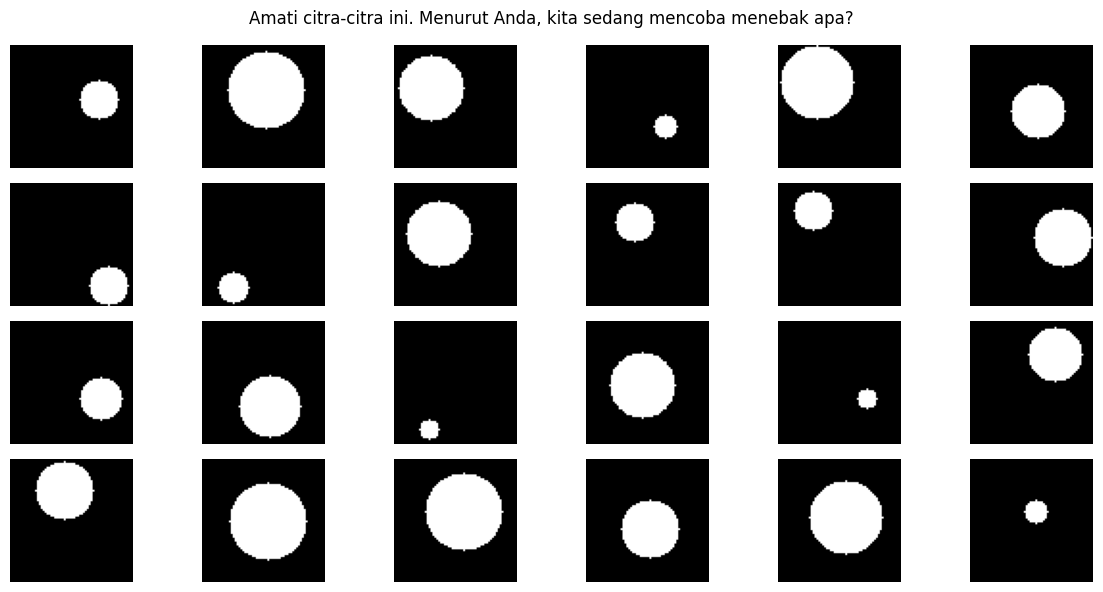

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

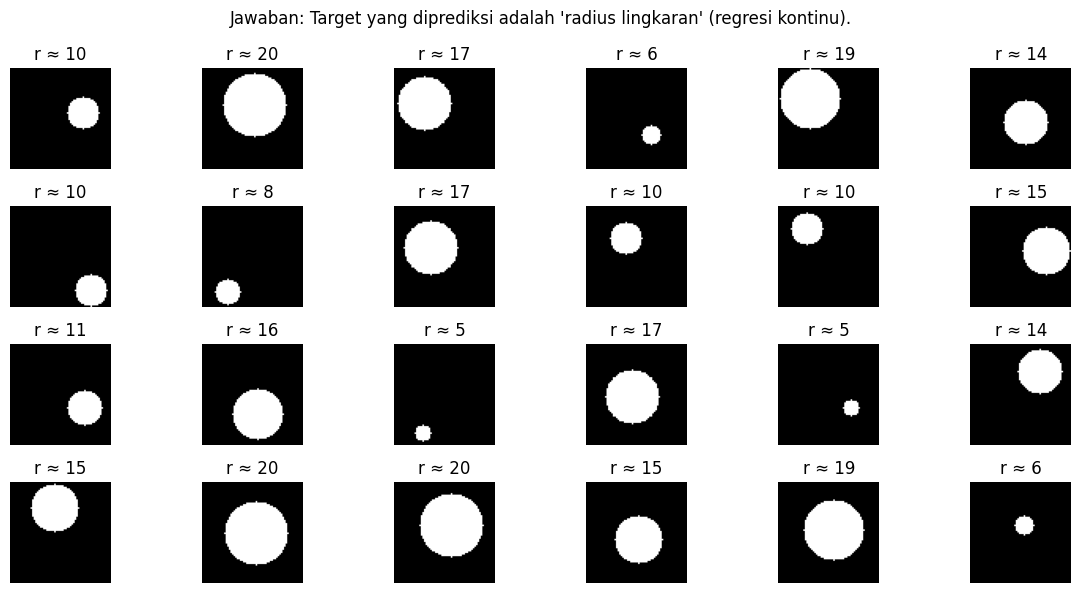

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
MAE=0.988 | RMSE=1.186 | R²=0.933


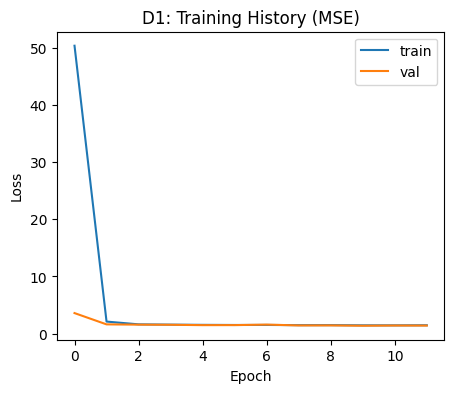

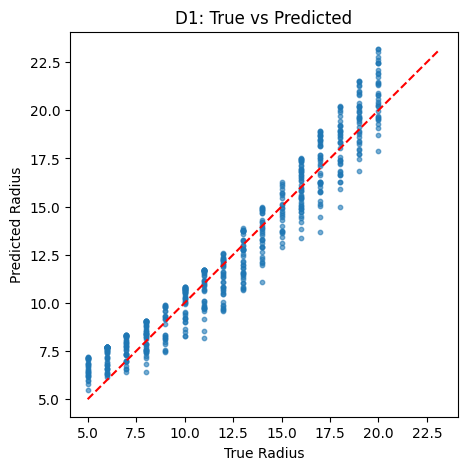

In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, c = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

# Plot history & True vs Predicted:
# Plot loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5, 5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

## Praktikum D2 - Menebak Umur Manusia dari Foto Wajah (UTKFace)

In [ ]:
# Jalankan ini di awal notebook
from google.colab import files
import os
import shutil

# Minta upload file kaggle.json
if not os.path.exists("kaggle.json"):
    files.upload() # pilih file kaggle.json dari komputer Anda

# Siapkan koneksi Kaggle
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    print("Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")

!pip -q install kaggle

Kaggle API siap digunakan.


In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
replace /content/utk/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


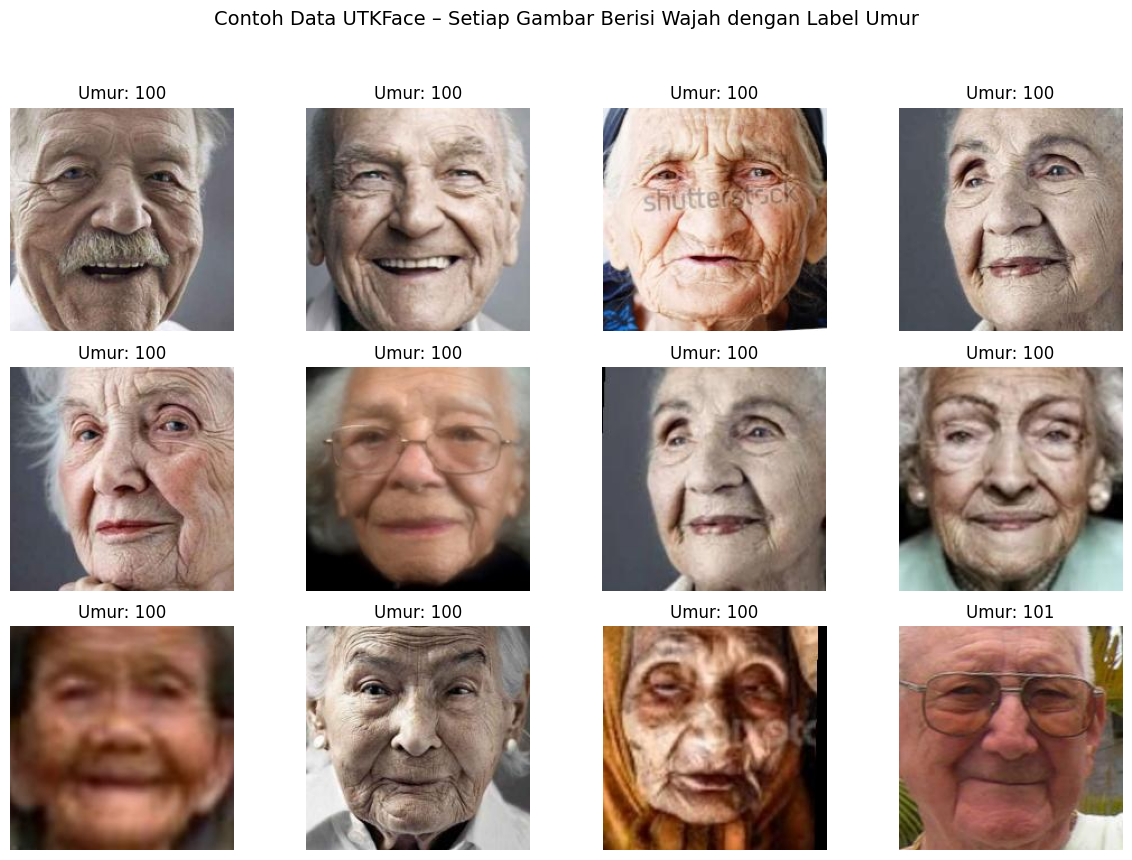

In [ ]:
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

# Ambil path semua gambar
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

# Tampilkan 12 gambar pertama
plt.figure(figsize=(12, 9))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    try:
        age = int(os.path.basename(f).split("_")[0])
        img = Image.open(f)
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Umur: {age}")
        plt.axis("off")
    except (ValueError, IndexError):
        # Melewati file yang namanya tidak sesuai format
        continue
plt.suptitle("Contoh Data UTKFace – Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    try:
        return int(os.path.basename(fp).split('_')[0])
    except (ValueError, IndexError):
        return None # Mengembalikan None jika nama file tidak valid

all_files = glob.glob("/content/utk/UTKFace/*.jpg")
ages = [parse_age_from_name(f) for f in all_files]

# Filter file yang tidak memiliki label umur yang valid
valid_files = [f for f, age in zip(all_files, ages) if age is not None]
valid_ages = [age for age in ages if age is not None]

ages_np = np.array(valid_ages, dtype=np.float32)

train_files, test_files, y_train, y_test = train_test_split(
    valid_files, ages_np, test_size=0.2, random_state=42
)

IMG_SIZE = 160
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("Dataset siap dilatih.")

Dataset siap dilatih.


In [ ]:
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0) # Preprocessing sesuai MobileNetV2
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='mse',
              metrics=['mae'])
model.summary()

Hardware: GPU


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - loss: 341.6139 - mae: 13.8185 - val_loss: 162.1059 - val_mae: 9.3175 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 155.7696 - mae: 9.3334 - val_loss: 145.1655 - val_mae: 8.7093 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 145.3338 - mae: 8.9125 - val_loss: 145.0294 - val_mae: 8.5968 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - loss: 140.3260 - mae: 8.7535 - val_loss: 138.5712 - val_mae: 8.4253 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 134.7333 - mae: 8.5375 - val_loss: 136.3292 - val_mae: 8.3280 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 131.3043 - mae: 8.4217 - val_loss: 136.7498 - val_mae: 8.3122 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - loss: 130.0874 - mae: 8.3621 - val_loss: 136.1385 - val

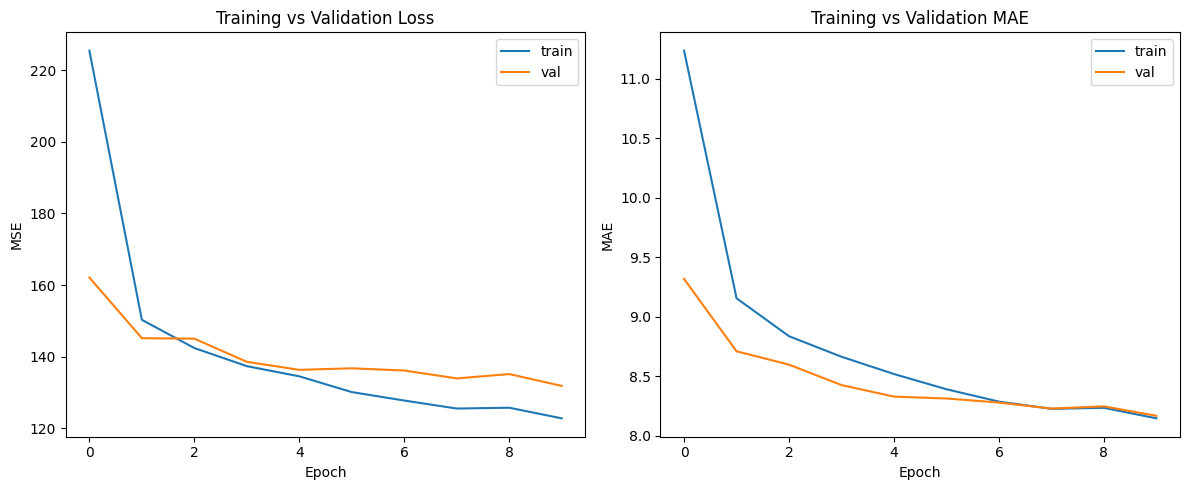

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 191.4346 - mae: 10.2685 - val_loss: 165.9060 - val_mae: 9.6488 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 75.7234 - mae: 6.5312 - val_loss: 125.7827 - val_mae: 8.3465 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 51.3402 - mae: 5.4297 - val_loss: 112.5916 - val_mae: 7.8042 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - loss: 37.5758 - mae: 4.6978 - val_loss: 124.0654 - val_mae: 7.9052 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 30.1214 - mae: 4.1830 - val_loss: 119.9404 - val_mae: 7.7686 - learning_rate: 1.0000e-04


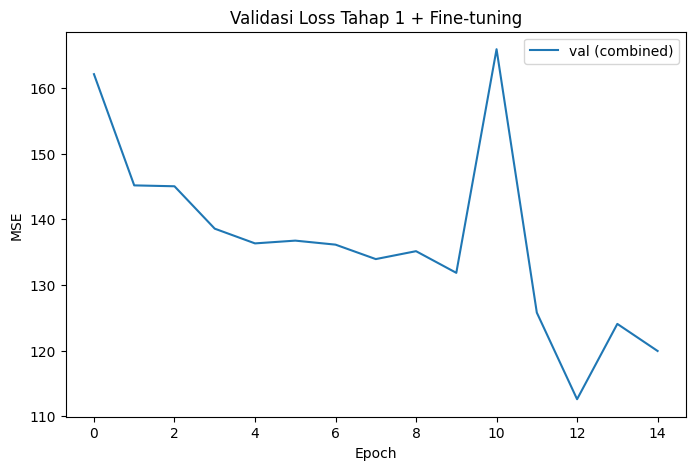

In [ ]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='mse',
              metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.figure(figsize=(8, 5))
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()

MAE = 7.80 tahun
RMSE = 10.61 tahun
R² = 0.724


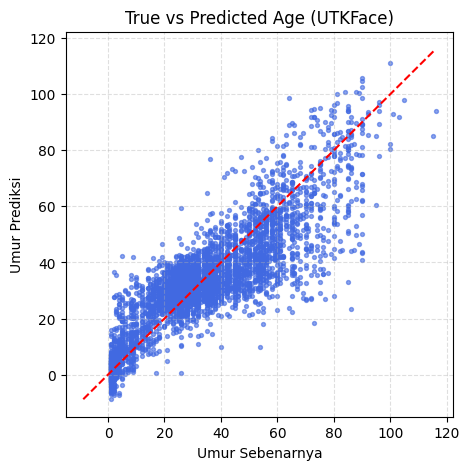

In [ ]:
from math import sqrt

# Lakukan prediksi pada seluruh data test
y_pred_list = []
for batch_images, batch_labels in test_ds:
    preds = model.predict(batch_images, verbose=0).ravel()
    y_pred_list.extend(preds)
y_pred = np.array(y_pred_list)

# Evaluasi
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R² = {r2:.3f}")

# Plot "umur sebenarnya vs umur prediksi":
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

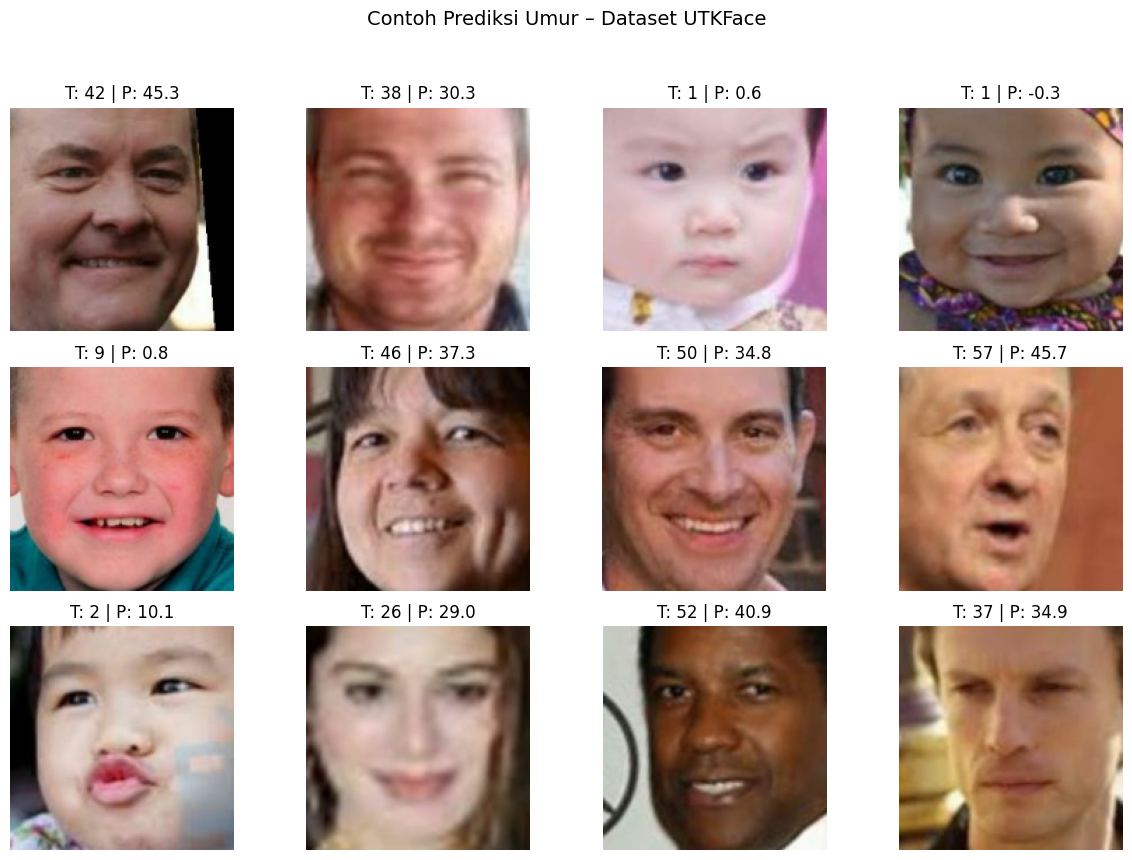

In [ ]:
import random

# Ambil 12 file acak dari data test
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12, 9))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])

    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T: {true_age} | P: {pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur – Dataset UTKFace", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Penugasan 3

Silakan unggah foto wajahmu...


Saving WhatsApp Image 2025-10-16 at 16.58.49_0499a68b.jpg to WhatsApp Image 2025-10-16 at 16.58.49_0499a68b.jpg
Foto 'WhatsApp Image 2025-10-16 at 16.58.49_0499a68b.jpg' berhasil diunggah.


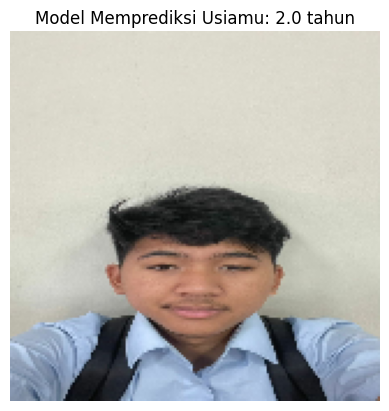

In [ ]:
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Upload fotomu
print("Silakan unggah foto wajahmu...")
uploaded = files.upload()

# 2. Ambil nama file yang diupload
if len(uploaded.keys()) > 0:
    my_photo_path = list(uploaded.keys())[0]
    print(f"Foto '{my_photo_path}' berhasil diunggah.")

    # 3. Proses gambar sesuai dengan model D2
    IMG_SIZE_D2 = 160 # Ingat, model D2 dilatih dengan ukuran 160x160
    img = tf.io.read_file(my_photo_path)
    img = tf.image.decode_image(img, channels=3) # decode_image lebih fleksibel (jpg/png)
    img = tf.image.resize(img, [IMG_SIZE_D2, IMG_SIZE_D2])
    img_tensor = img / 255.0

    # 4. Lakukan prediksi menggunakan model dari D2 (pastikan variabel 'model' masih ada)
    # Modelnya harus model yang sudah di-fine-tuning
    predicted_age = model.predict(tf.expand_dims(img_tensor, 0), verbose=0)[0][0]

    # 5. Tampilkan hasilnya
    plt.imshow(img_tensor)
    plt.axis('off')
    plt.title(f"Model Memprediksi Usiamu: {predicted_age:.1f} tahun")
    plt.show()
else:
    print("Tidak ada file yang diunggah.")

## Praktikum D3 - Menilai "Kepopuleran Hewan Peliharaan" dari Foto

In [1]:
!pip install --upgrade kaggle -q

In [2]:
from google.colab import files
files.upload() # pilih kaggle.json dari komputer Anda

import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle.json
✅ Kaggle API siap digunakan.


In [3]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

✅ Dataset Pawpularity berhasil diekstrak.


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

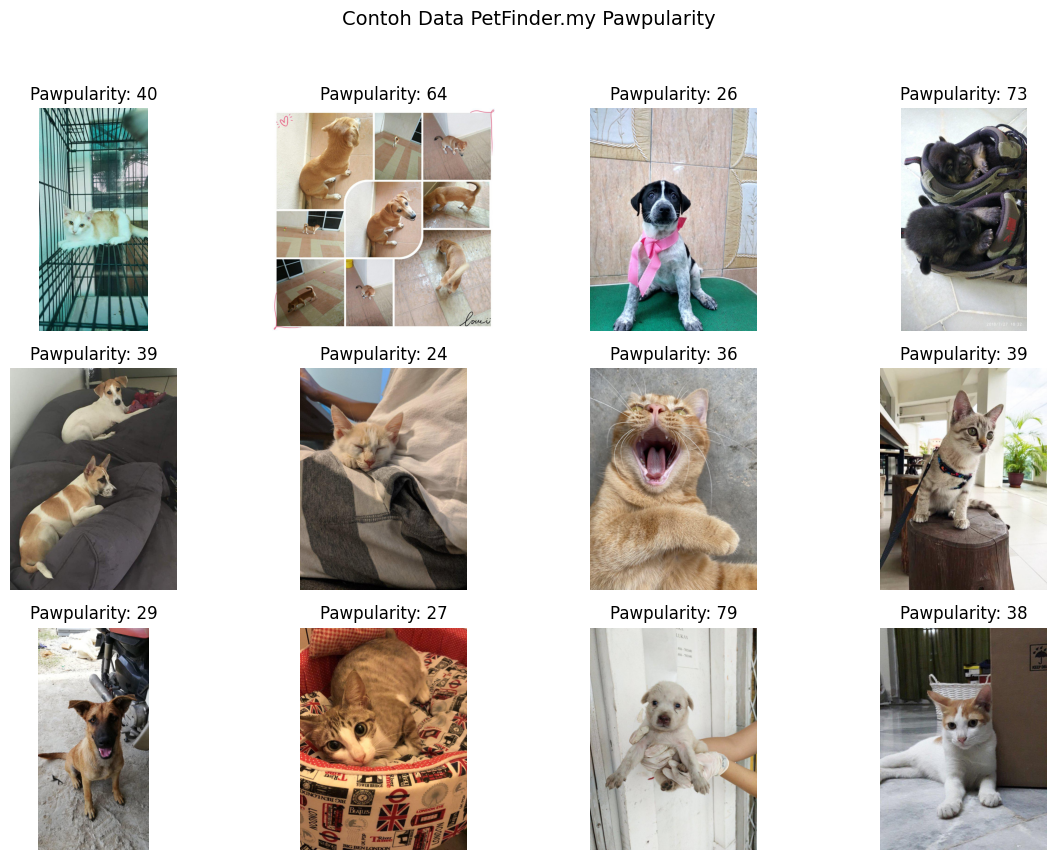

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 9))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan: {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

Dataset siap digunakan: 7929 untuk training, 1983 untuk validasi.


In [6]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)
model_paw = tf.keras.Model(inputs, outputs)

model_paw.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_paw.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 104s 502ms/step - loss: 804.9539 - mae: 21.5514 - val_loss: 480.3568 - val_mae: 16.2442 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 86s 205ms/step - loss: 422.1655 - mae: 15.1728 - val_loss: 431.4098 - val_mae: 15.3169 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 234ms/step - loss: 397.7014 - mae: 14.7733 - val_loss: 410.3492 - val_mae: 14.6739 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 36s 196ms/step - loss: 369.2706 - mae: 14.2451 - val_loss: 394.1351 - val_mae: 14.7236 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - loss: 356.2019 - mae: 13.9773 - val_loss: 385.5458 - val_mae: 14.4624 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - loss: 356.8564 - mae: 14.0998 - val_loss: 376.8769 - val_mae: 14.1532 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - loss: 354.5331 - mae: 13.9491 - val_

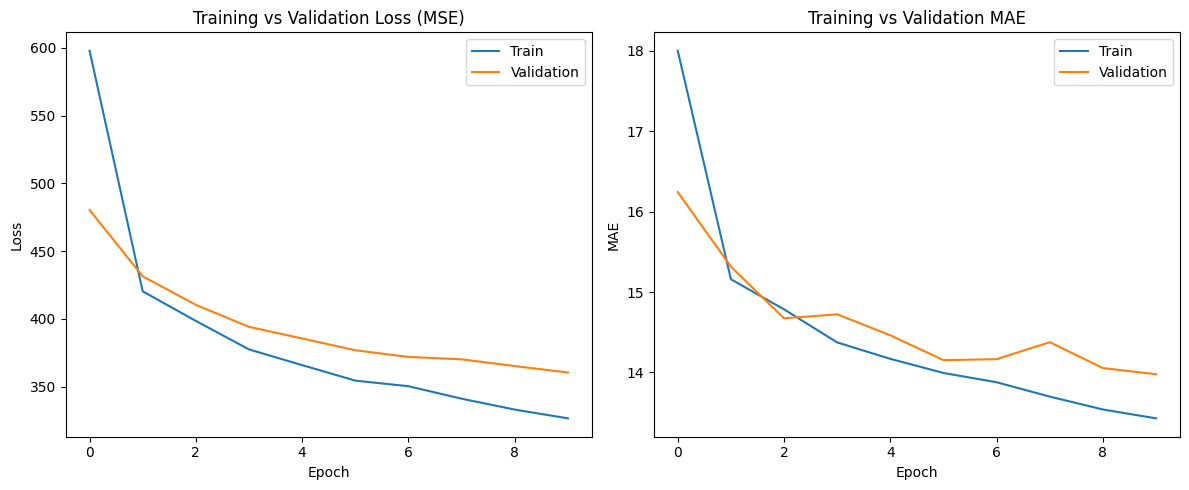

In [7]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]
# Di jobsheet hanya 1 epoch, kita bisa coba lebih banyak misal 10
history_paw = model_paw.fit(train_ds, validation_data=val_ds, epochs=10,
                            callbacks=cb, verbose=1)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_paw.history['loss'], label='Train')
plt.plot(history_paw.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_paw.history['mae'], label='Train')
plt.plot(history_paw.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()

MAE = 13.98
RMSE = 18.99
R² = 0.185


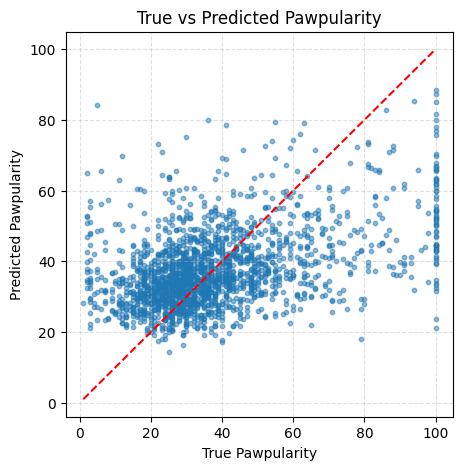

In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred_paw_list = []
for batch_images, batch_labels in val_ds:
    preds = model_paw.predict(batch_images, verbose=0).ravel()
    y_pred_paw_list.extend(preds)
y_pred_paw = np.array(y_pred_paw_list)

mae = mean_absolute_error(y_true, y_pred_paw)
rmse = sqrt(np.mean((y_true - y_pred_paw)**2))
r2 = r2_score(y_true, y_pred_paw)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred_paw, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred_paw.min()), max(y_true.max(), y_pred_paw.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

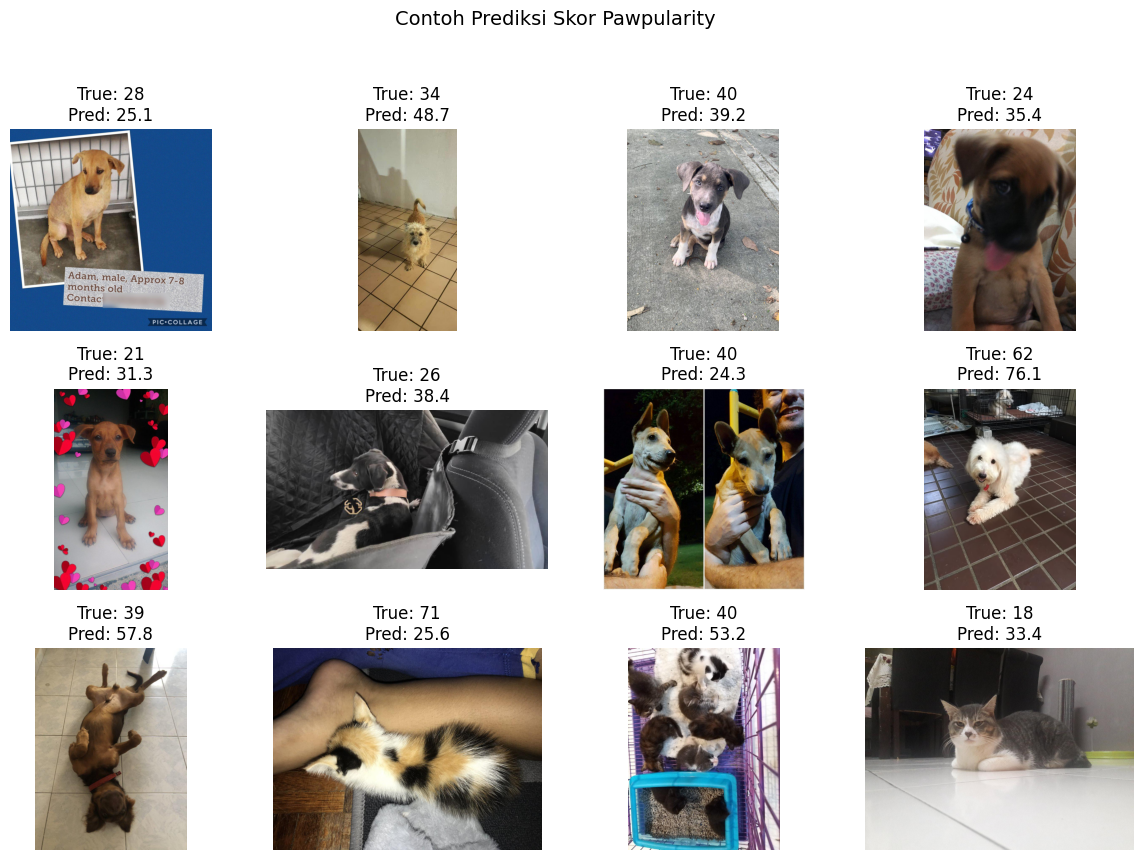

In [9]:
import random

sample_rows = val_df.sample(12, random_state=1)
plt.figure(figsize=(12, 9))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    img_tensor, label = load_image(row.path, row.Pawpularity)

    pred = model_paw.predict(tf.expand_dims(img_tensor, 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
# tantangan

import tensorflow as tf
from sklearn.model_selection import train_test_split

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Buat layer augmentasi
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

def load_image_with_aug(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

# Pipeline untuk data training: muat gambar, lalu augmentasi
train_ds_aug = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_image_with_aug, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096) \
    .batch(64) \
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE) \
    .prefetch(tf.data.AUTOTUNE)

# Pipeline untuk data validasi: TIDAK PERLU augmentasi
val_ds_aug = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity'])) \
    .map(load_image_with_aug, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64) \
    .prefetch(tf.data.AUTOTUNE)

print("Dataset dengan augmentasi siap digunakan.")

# Selanjutnya, kamu bisa melatih ulang modelmu menggunakan `train_ds_aug` dan `val_ds_aug`
# Contoh: history = model_paw.fit(train_ds_aug, validation_data=val_ds_aug, ...)

Dataset dengan augmentasi siap digunakan.


### Penugasan 4

In [ ]:
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# 1. Upload foto
print("Silakan unggah foto pribadi atau hewan peliharaanmu...")
uploaded = files.upload()

# 2. Ambil nama file
if len(uploaded.keys()) > 0:
    my_pet_photo_path = list(uploaded.keys())[0]
    print(f"Foto '{my_pet_photo_path}' berhasil diunggah.")

    # 3. Proses gambar sesuai dengan model D3
    IMG_SIZE_D3 = 224 # Model D3 dilatih dengan ukuran 224x224

    # Kita gunakan fungsi load_image dari D3 untuk konsistensi
    # Definisikan lagi di sini untuk jaga-jaga
    def load_single_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE_D3, IMG_SIZE_D3])
        return tf.cast(img, tf.float32) / 255.0

    img_tensor_d3 = load_single_image(my_pet_photo_path)

    # 4. Lakukan prediksi menggunakan model dari D3 (variabel 'model_paw')
    predicted_score = model_paw.predict(tf.expand_dims(img_tensor_d3, 0), verbose=0)[0][0]

    # 5. Tampilkan hasilnya
    plt.imshow(Image.open(my_pet_photo_path))
    plt.axis('off')
    plt.title(f"Model Memprediksi Skor Pawpularity: {predicted_score:.1f} / 100")
    plt.show()
else:
    print("Tidak ada file yang diunggah.")

Silakan unggah foto pribadi atau hewan peliharaanmu...
